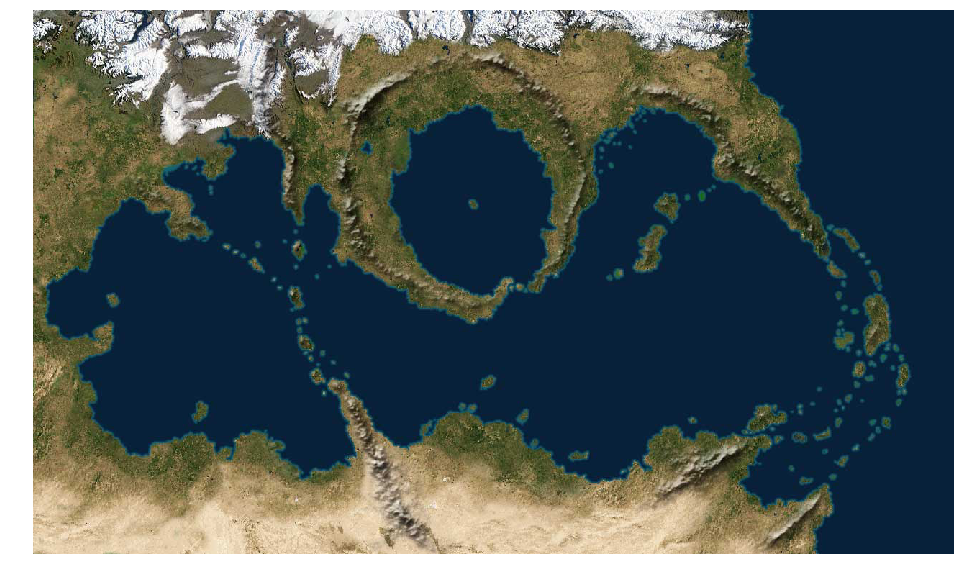

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import skimage
from skimage import color, transform
import glob

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10
plt.axis('off')

imgpath = glob.glob("./map.png")[0]
img = mpimg.imread(imgpath)

plt.imshow(img);

In [2]:
# convert an rgb image to rgba
def rgb2rgba(img):
    return np.dstack((img, (color.rgb2gray(img) != -1)))

In [3]:
def max_sq_size(img, n):
    height = len(img)
    width = len(img[0])
    
    px = int(math.ceil(math.sqrt(n * width/height)))
    if (math.floor(px * height/width) * px < n):
        sx = height / int(math.ceil(px * height/width))
    else:
        sx = width / px
    
    py = int(math.ceil(math.sqrt(n * height/width)))
    if (math.floor(py * width/height)* py < n):
            sy = width / int(math.ceil(py * width/height))
    else:
            sy = height / py
            
    return min(sx, sy)

In [4]:
# create a square tiling of the image
def img_to_sqs(img, side_length):
    img_rgba = rgb2rgba(img)
    tiles = []
    for y in range(0, len(img)-side_length + 1, side_length):
        tiles += [[]]
        for x in range(0, len(img[0])-side_length + 1, side_length):
            tiles[y/side_length] += [img_rgba[y:y+side_length, x:x+side_length]]
    return tiles

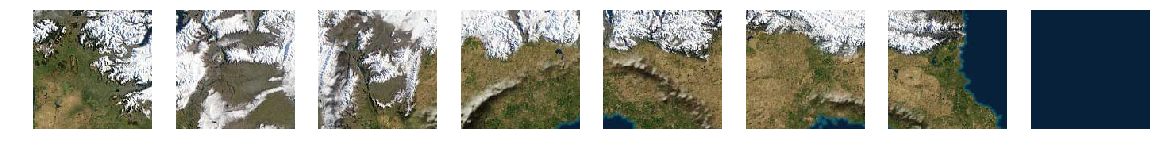

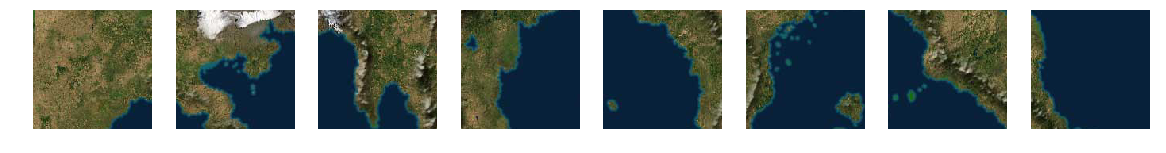

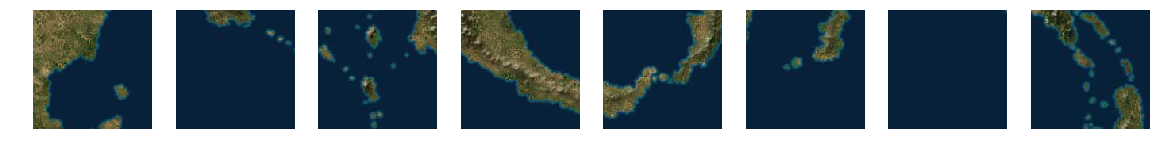

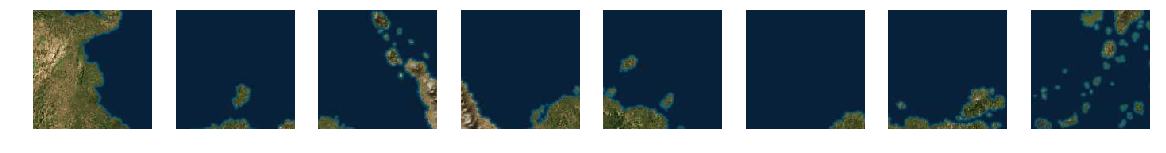

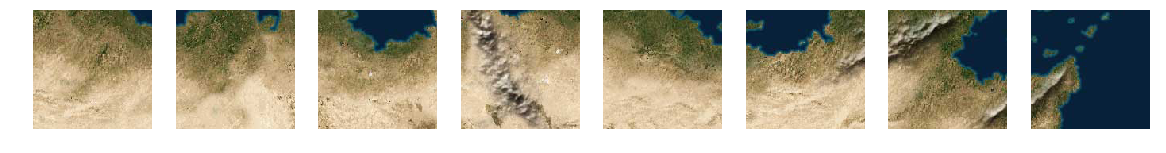

In [5]:
for y,row in enumerate(img_to_sqs(img, 150)):
    plt.figure()
    tiles = len(row)
    for x,tile in enumerate(row):
        plt.subplot(1, tiles, x+1)
        plt.axis('off')
        plt.imshow(tile, interpolation='nearest')

In [6]:
# a boolean mask in the shape of an isosceles triangle of given base and height
def generate_tri_mask(base, height):
    mask = np.zeros((height, base, 4))
    center = base / 2
    for y in range(height):
        width = int((y / float(height)) * base)
        mask[y][center - (width / 2):center + (width / 2)] = [1, 1, 1, 1]
    return mask

In [7]:
# create a triangular tiling of the image
def img_to_tris(img, side_length):
    height = int(math.sqrt(side_length**2 - (side_length / 2)**2))
    tiles = []
    img_rgba = rgb2rgba(img)
    mask = generate_tri_mask(side_length, height)
    for y in range(0, len(img)-height + 1, height):
        tiles += [[]]
        for x in range(0, len(img[0])-side_length + 1, side_length / 2):
            mask = transform.rotate(mask, 180)
            tiles[y/height] += [img_rgba[y:y+height, x:x+side_length] * mask]
    return tiles

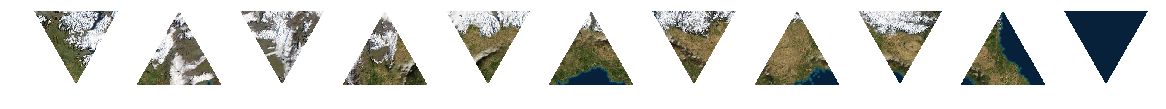

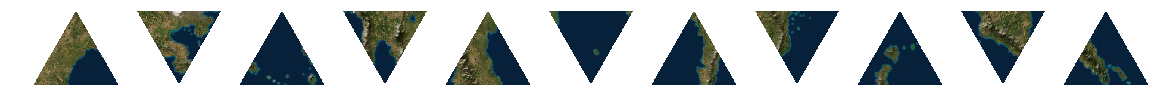

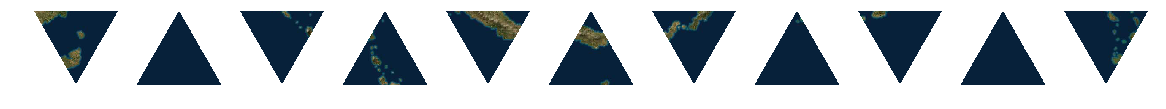

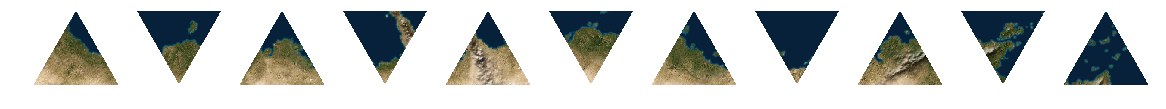

In [8]:
for y,row in enumerate(img_to_tris(img, 200)):
    plt.figure()
    tiles = len(row)
    for x,tile in enumerate(row):
        plt.subplot(1, tiles, x+1)
        plt.axis('off')
        plt.imshow(tile, interpolation='nearest')

In [9]:
# a boolean mask in the shape of a regular hexagon with side length s
def generate_hex_mask(s):
    max_width = 2 * s
    min_width = int(math.sqrt(3) * s)
    dim = 4
    mask = np.zeros((max_width, min_width, dim))
    in_radius = min_width / 2 # the inscribed radius
    for y in range(s / 2, 3 * s / 2):
        mask[y][:] = [1] * dim
    for y in range(s / 2):
        width = int((y / float(s / 2)) * min_width)
        mask[y][in_radius - (width / 2):in_radius + (width / 2)] = [1] * dim
        mask[-1 - y][in_radius - (width / 2):in_radius + (width / 2)] = [1] * dim
    return mask

In [10]:
# create a hexagonal tiling of the image
def img_to_hexs(img, side_length):
    height = side_length * 2
    width = int(math.sqrt(3) * side_length)
    tiles = []
    img_rgba = rgb2rgba(img)
    mask = generate_hex_mask(side_length)
    x_offset = 0
    y_offset = side_length / 2
    for y in range(0, len(img)-height + 1, height - y_offset):
        tiles += [[]]
        for x in range(0 + x_offset, len(img[0])-width, width):
            tile = img_rgba[y:y+height, x:x+width]
            tiles[y/(height - y_offset)] += [tile * mask]
        if x_offset:
            x_offset = 0
        else:
            x_offset = width / 2
    return tiles

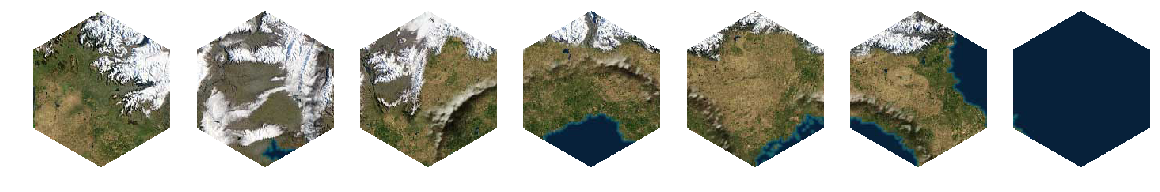

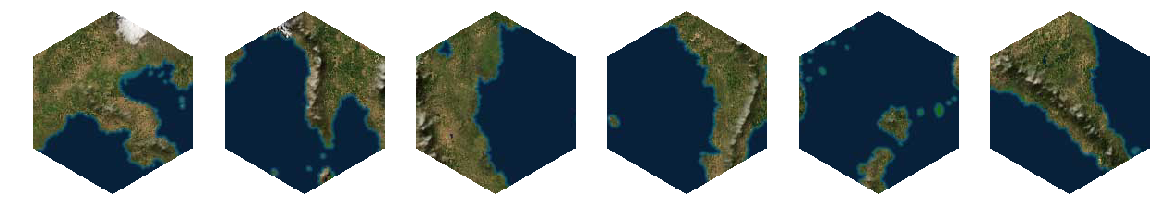

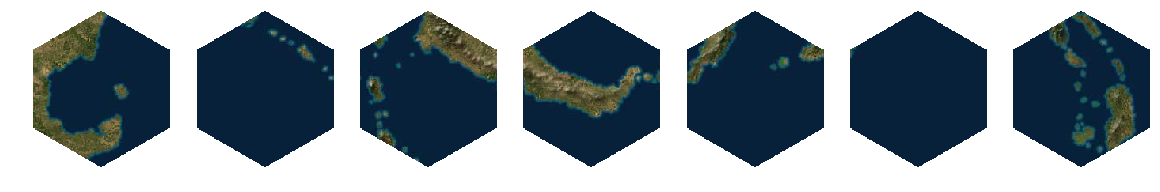

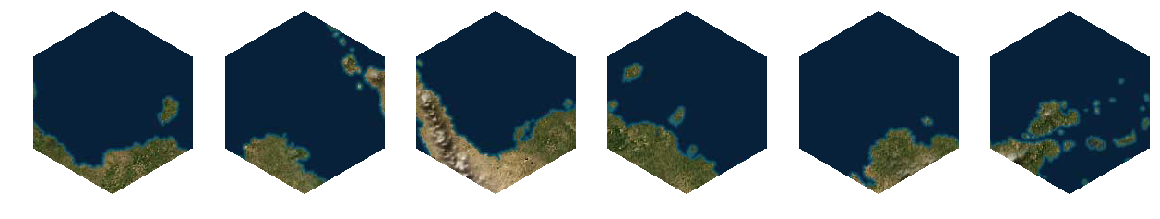

In [11]:
for y,row in enumerate(img_to_hexs(img, 100)):
    plt.figure()
    tiles = len(row)
    for x,tile in enumerate(row):
        plt.subplot(1, tiles, x+1)
        plt.axis('off')
        plt.imshow(tile, interpolation='nearest')

In [18]:
def img_to_tiles(img, side_length, tile_shape='h'):
    if tile_shape in ['h', 'hex', 'hexagon']:
        return img_to_hexs(img, side_length)
    if tile_shape in ['s', 'sq', 'square']:
        return img_to_sqs(img, side_length)
    if tile_shape in ['t', 'tri', 'triangle']:
        return img_to_tris(img, side_length)
    raise ValueError("'{}' is not valid tile shape".format(tile_shape))